In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from scipy.stats import binned_statistic
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 1
%aimport data_processing
%aimport loading_datasets
from data_processing import *
from loading_datasets import *

### Calculate FQ from emerge data

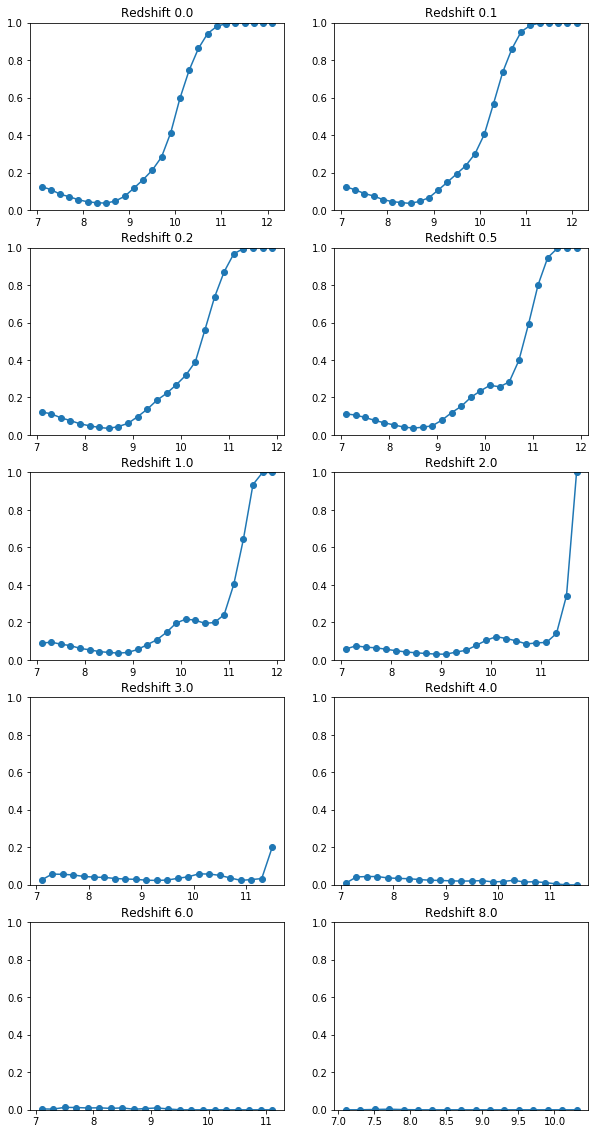

In [5]:
galfile_directory = '/scratch/data/galcats/P200new/'

redshifts = [0,.1,.2,.5,1,2,3,4,6,8]

fig = plt.figure(figsize=(10,20))

for i_redshift, redshift in enumerate(redshifts):
    scale_factor = 1/(1 + redshift)
    galaxies, data_keys = load_galfiles(redshifts=[redshift], equal_numbers=False)
    sfr_log = galaxies[:, data_keys['SFR']]
    stellar_mass_log = galaxies[:, data_keys['Stellar_mass']]

    sfr = np.power(10, sfr_log)
    stellar_mass = np.power(10, stellar_mass_log)

    ssfr = sfr / stellar_mass
    ssfr_log = np.log10(ssfr)

    # now bin according to stellar mass
    min_stellar_mass_log = np.min(stellar_mass_log)
    max_stellar_mass_log = np.max(stellar_mass_log)
    bin_width = 0.2
    stellar_mass_bin_edges = np.arange(min_stellar_mass_log, max_stellar_mass_log + bin_width, bin_width)
    stellar_mass_bin_mids = [(stellar_mass_bin_edges[i] + stellar_mass_bin_edges[i+1])/2 for i in range(len(stellar_mass_bin_edges)-1)]

    bin_counts, bin_edges, bin_nrs = binned_statistic(stellar_mass_log, ssfr_log, statistic='count', bins=stellar_mass_bin_edges)

    #Define SSFR cut
    ssfrcut = 0.3

    #Define Cosmology
    H0  = 67.81
    Om0 = 0.308

    #Compute age
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    age = cosmo.age([redshift]).value[0]
    ssfr_cutoff = ssfrcut/age/1.e9
    log_ssfr_cutoff = np.log10(ssfr_cutoff)

    fq_array = np.zeros(len(bin_counts))

    for i_bin in range(len(bin_counts)):
        in_bin_indeces = bin_nrs == (i_bin+1)
        n_quenched = np.sum(ssfr_log[in_bin_indeces] < log_ssfr_cutoff)
        frac_quenched = n_quenched / bin_counts[i_bin]
        fq_array[i_bin] = frac_quenched

    ax = plt.subplot(5, 2, i_redshift+1)
    ax.plot(stellar_mass_bin_mids, fq_array, 'o-')
    ax.set_title('Redshift {:.1f}'.format(redshift))
    ax.set_ylim(bottom=0, top=1)
    
plt.show()

In [ ]:
original_directory = '/scratch/data/galcats/P200new/'

redshifts = [0,.1,.2,.5,1,2,3,4,6,8]

fig = plt.figure(figsize=(10,20))

for i_redshift, redshift in enumerate(redshifts):
    
    file_name = 'galaxies.Z{:02.0f}.h5'.format(10*redshift)
    galfile = pd.read_hdf(original_directory + file_name)
    galaxies = galfile.values
    gal_header = galfile.keys().tolist()

    data_dict = {}
    for col_nr, key in enumerate(gal_header):
        data_dict[key] = col_nr
    
    scale_factor = 1/(1 + redshift)
    sfr_log = galaxies[:, data_keys['SFR']]
    stellar_mass_log = galaxies[:, data_keys['Stellar_mass']]

    sfr = np.power(10, sfr_log)
    stellar_mass = np.power(10, stellar_mass_log)

    ssfr = sfr / stellar_mass
    print('nr of zero ssfr: ', np.sum(ssfr == 0))
    ssfr_log = np.zeros(shape=np.shape(ssfr))
    ssfr_log[ssfr > 0] = np.log10(ssfr[ssfr > 0])
    ssfr_log[ssfr == 0] = 1e-20

    # now bin according to stellar mass
    min_stellar_mass_log = np.min(stellar_mass_log)
    max_stellar_mass_log = np.max(stellar_mass_log)
    bin_width = 0.2
    stellar_mass_bin_edges = np.arange(min_stellar_mass_log, max_stellar_mass_log + bin_width, bin_width)
    stellar_mass_bin_mids = [(stellar_mass_bin_edges[i] + stellar_mass_bin_edges[i+1])/2 for i in range(len(stellar_mass_bin_edges)-1)]

    bin_counts, bin_edges, bin_nrs = binned_statistic(stellar_mass_log, ssfr_log, statistic='count', bins=stellar_mass_bin_edges)

    H_0 = 67.81 / (3.09e19) # 1/s
    H_0 = H_0 * 60 * 60 * 24 * 365 # 1/yr
    h_r = H_0 * np.sqrt(1e-3*scale_factor**(-4) + 0.308*scale_factor**(-3) + 0*scale_factor**(-2) + 0.692)
    ssfr_cutoff = 0.3*h_r
    log_ssfr_cutoff = np.log10(ssfr_cutoff)

    fq_array = np.zeros(len(bin_counts))

    for i_bin in range(len(bin_counts)):
        in_bin_indeces = bin_nrs == (i_bin+1)
        n_quenched = np.sum(ssfr_log[in_bin_indeces] < log_ssfr_cutoff)
        frac_quenched = n_quenched / bin_counts[i_bin]
        fq_array[i_bin] = frac_quenched

    ax = plt.subplot(5, 2, i_redshift+1)
    ax.plot(stellar_mass_bin_mids, fq_array, 'o-')
    ax.set_title('Redshift {:.1f}'.format(redshift))
    ax.set_ylim(bottom=0, top=1)
    
plt.show()

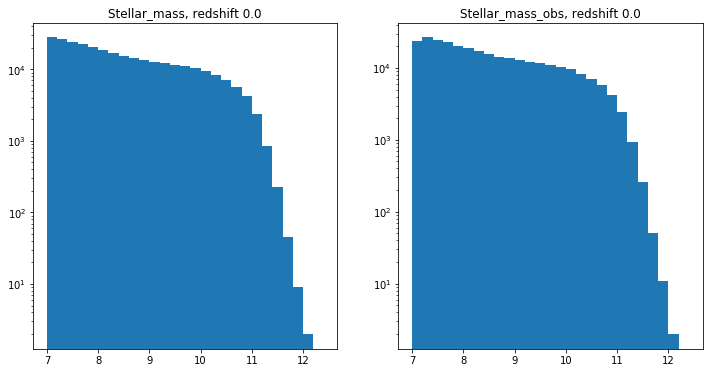

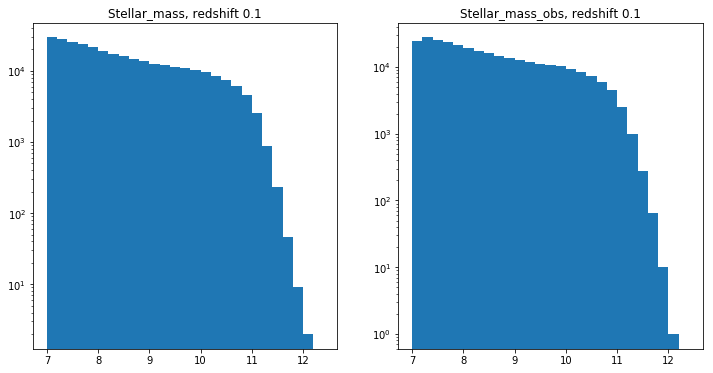

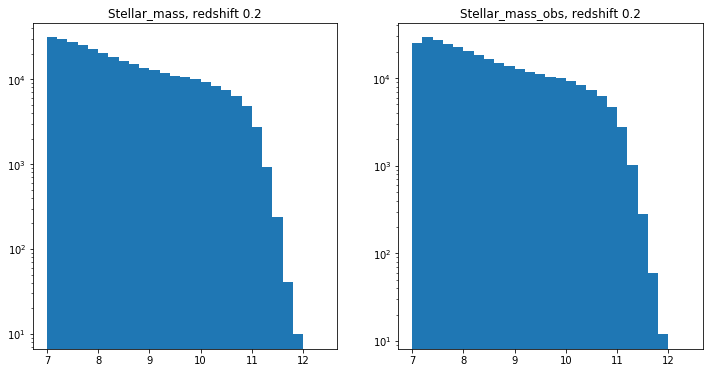

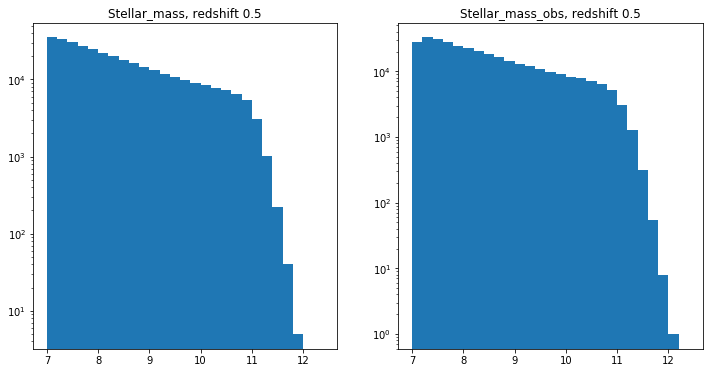

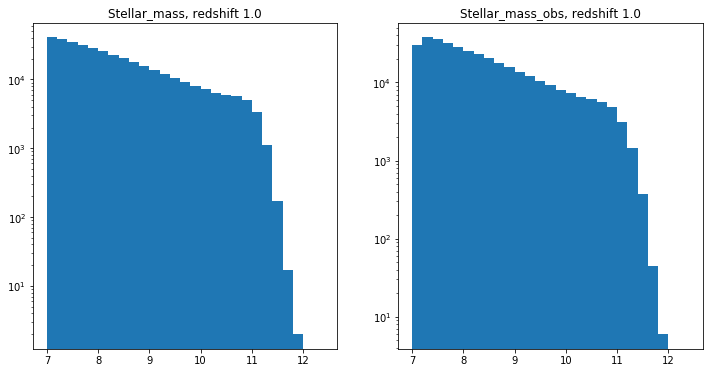

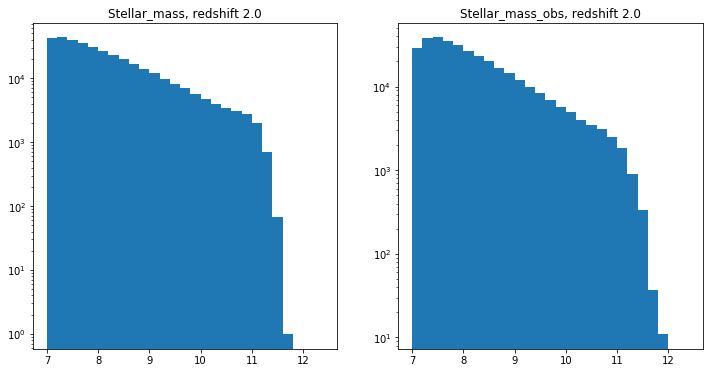

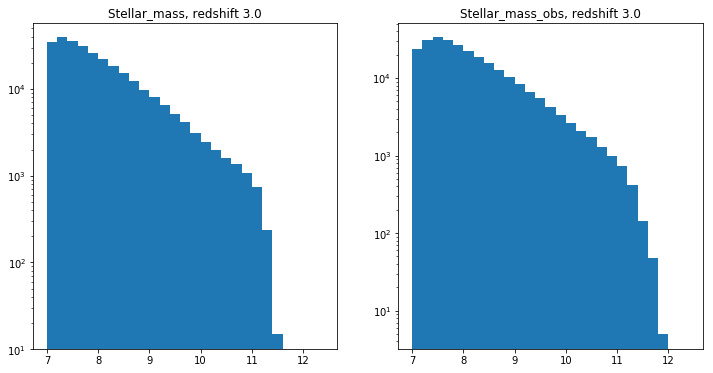

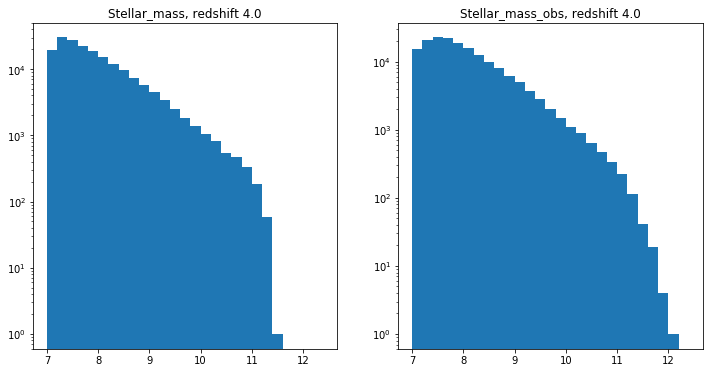

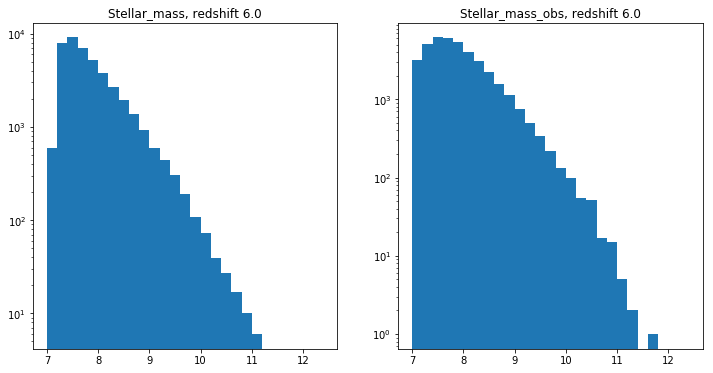

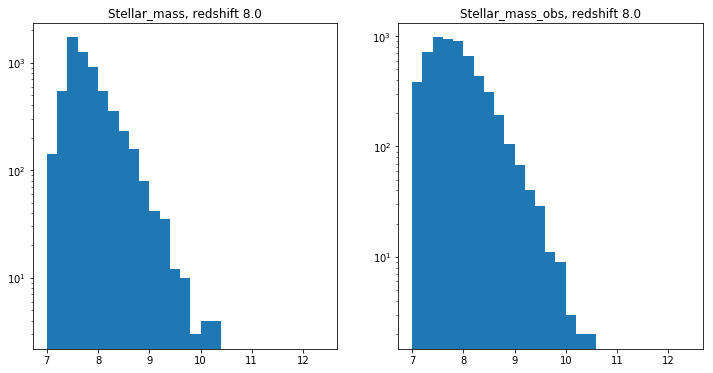

In [5]:
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
for redshift in redshifts:
    galaxies, data_keys = load_galfiles(redshifts=[redshift], equal_numbers=False)
    # galaxies, data_keys = load_single_galfile(redshift=0)
    # print(data_keys)

    # print(np.isnan(galaxies[:, data_keys['Halo_mass']]).any())
    # print(np.isinf(galaxies[:, data_keys['Halo_mass']]).any())

#     plt.xscale('log')
    
    fig = plt.figure(figsize=(12,6))
    ax = plt.subplot(1,2,1)
    ax.hist(galaxies[:, data_keys['Stellar_mass']], bins=np.arange(7, 12.5, 0.2), density=False, log=True)
    ax.set_title('Stellar_mass, redshift {:.1f}'.format(redshift))
    ax = plt.subplot(1,2,2)
    ax.hist(galaxies[:, data_keys['Stellar_mass_obs']], bins=np.arange(7, 12.5, 0.2), density=False, log=True)
    ax.set_title('Stellar_mass_obs, redshift {:.1f}'.format(redshift))
    plt.show()

In [ ]:
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
galaxies, data_keys = load_galfiles(redshifts=redshifts, equal_numbers=False)
training_data_dict = divide_train_data(galaxies, data_keys, network_args, redshifts, outputs_to_weigh=outputs_to_weigh, 
                                       weigh_by_redshift=weigh_by_redshift, total_set_size=tot_nr_points, 
                                       train_frac=train_frac, val_frac=val_frac, 
                                       test_frac=test_frac, emerge_targets=True)
training_data_dict = normalise_data(training_data_dict, norm)

In [ ]:
# galaxies, data_keys = load_single_galfile(redshift=0)
# print(data_keys)

# print(np.isnan(galaxies[:, data_keys['Halo_mass']]).any())
# print(np.isinf(galaxies[:, data_keys['Halo_mass']]).any())

#     plt.xscale('log')
for redshift in redshifts:

    
#     relevant_inds = galaxies[:, data_keys['Redshift']] == redshift
#     plt.hist(galaxies[relevant_inds, data_keys['Stellar_mass']], bins=np.arange(7, 12.5, 0.2), density=False, log=True)

    relevant_inds = training_data_dict['data_redshifts']['train_data'] == redshift
    plt.hist(training_data_dict['output_train_dict']['Stellar_mass'][relevant_inds], bins=np.arange(7, 12.5, 0.2), density=False, log=True)
    
    plt.title('redshift {:.1f}, tot nr points: {:d}'.format(redshift, np.sum(relevant_inds)))
    plt.show()

In [ ]:
galaxies, data_keys = load_galfiles(redshifts=[0], equal_numbers=False)


In [ ]:
features_to_keep = ['Halo_mass', 'Halo_mass_peak', 
                    'Halo_radius', 'Concentration', 'Halo_spin', 'Scale_peak_mass',
                    'Scale_half_mass', 'Type']
norm = 'zero_mean_unit_std' # 'zero_mean_unit_std', 'zero_to_one'
indeces_to_keep = []
for key in features_to_keep:
    indeces_to_keep.append(data_keys[key])
x = galaxies[:, indeces_to_keep]
n_data_points = np.shape(galaxies)[0]

if norm == 'zero_mean_unit_std':
    x_means = np.mean(x, 0)
    x_stds = np.std(x, 0)

    x_norm = (x - x_means) / x_stds
elif norm == 'zero_to_one':
    x_max = np.max(x, 0)
    x_min = np.min(x, 0)
    
    x_norm = (x - x_min) / (x_max - x_min)
else:
    print('Provide a valid norm.')

if np.isnan(x_norm).any():
    print('Some of the values of the normed data is NaN.')
if np.isinf(x_norm).any():
    print('Some of the values of the normed data is Inf.')

In [ ]:
### PCA Plot, assign colors according to SFR
equal_nrs_from_cats = False
tot_nr_points_to_plot = 1000

sfr_cutoff = 0
marker_size = [45, 1]

nr_components = 3
pca = PCA(n_components=nr_components)
pca.fit(x_norm)
x_red = pca.transform(x_norm)

if equal_nrs_from_cats:
    
    n_points_per_cat = int(tot_nr_points_to_plot/2)
    large_sfr_inds = np.where(galaxies[:, data_keys['SFR']] > sfr_cutoff)
    small_sfr_inds = np.where(galaxies[:, data_keys['SFR']] <= sfr_cutoff)
    large_sfr_inds_subset = np.random.choice(large_sfr_inds[0], n_points_per_cat, replace=False)
    small_sfr_inds_subset = np.random.choice(small_sfr_inds[0], n_points_per_cat, replace=False)
    
    title = 'PCA of data excluding baryonic properties. \nEqual nr of points from each category shown (%d).\nnorm: %s.' % \
            (n_points_per_cat, norm)
    
    
    
else:
    
    frac_pts_low_sfr = np.sum(galaxies[:, data_keys['SFR']] <= sfr_cutoff) / n_data_points
    frac_pts_high_sfr = 1 - frac_pts_low_sfr
    nr_pts_low_sfr = int(tot_nr_points_to_plot * frac_pts_low_sfr)
    nr_pts_high_sfr = int(tot_nr_points_to_plot * frac_pts_high_sfr)
    
    large_sfr_inds = np.where(galaxies[:, data_keys['SFR']] > sfr_cutoff)
    small_sfr_inds = np.where(galaxies[:, data_keys['SFR']] <= sfr_cutoff)
    large_sfr_inds_subset = np.random.choice(large_sfr_inds[0], nr_pts_high_sfr, replace=False)
    small_sfr_inds_subset = np.random.choice(small_sfr_inds[0], nr_pts_low_sfr, replace=False)
    
    title = 'PCA of data excluding baryonic properties. \n' + \
            'Ratio of points reflects the dataset ratio, %.1e points in total\nfraction of high SFR points is %.2e.\nnorm: %s.' % \
            (tot_nr_points_to_plot, frac_pts_high_sfr, norm)
    
%matplotlib notebook
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_red[large_sfr_inds_subset,0], x_red[large_sfr_inds_subset,1], 
           x_red[large_sfr_inds_subset,2], c='r', s=marker_size[0])
sc = ax.scatter(x_red[small_sfr_inds_subset,0], x_red[small_sfr_inds_subset,1], 
           x_red[small_sfr_inds_subset,2], c='b', s=marker_size[1])
#plt.colorbar(sc)
plt.legend(['SFR > %d' % (sfr_cutoff), 'SFR <= %d' % (sfr_cutoff)], loc = 'lower right')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')
plt.title(title, 
          fontsize=20)
plt.show()

In [ ]:
### PCA - Assign colors according to Stellar_mass and size according to SFR
max_size = 500
min_size = 5
n_points_to_show = 2000
colors = galaxies[:, data_keys['Stellar_mass']]
nr_components = 3
pca = PCA(n_components=nr_components)
pca.fit(x_norm)
x_red = pca.transform(x_norm)

%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

subset_indices = np.random.choice(n_data_points, n_points_to_show, replace=False)
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_red[subset_indices,0], x_red[subset_indices,1], 
           x_red[subset_indices,2], c=colors[subset_indices], s=10)
plt.colorbar(sc)
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')
plt.title('PCA of data excluding galaxy properties.\nColors refers to stellar mass.'+
          '\nnorm: %s.' % (norm), 
          fontsize=20)
plt.show()

In [ ]:
### Histogram over SFR and Stellar mass properties
bin_width_sfr = 0.1
bin_width_stellar_mass = 0.01
bin_width_halo_mass = 0.01

max_sfr = np.max(galaxies[:, data_keys['SFR']])
min_sfr = np.min(galaxies[:, data_keys['SFR']])
bins = np.arange(min_sfr, max_sfr + bin_width_sfr, bin_width_sfr)
%matplotlib inline
fig1 = plt.figure(figsize = (16,16))
ax1 = plt.subplot(321)
plt.hist(galaxies[:, data_keys['SFR']], bins = bins, density = False, label = 'SFR %s' % (unit_dict['SFR']))
plt.title('SFR. Bin widths: %.2f.' % (bin_width_sfr), fontsize=20)
plt.xlabel('SFR '+unit_dict['SFR'], fontsize=15)
ax2 = plt.subplot(322)
plt.hist(galaxies[:, data_keys['SFR']], bins = bins, density = True, log = True)
plt.title('SFR. Normalised bin counts,\nlogged y-axis. Bin widths: %.2f.' % (bin_width_sfr), fontsize=20)
plt.xlabel('SFR '+unit_dict['SFR'], fontsize=15)
#plt.show()

max_stellar_mass = np.max(galaxies[:, data_keys['Stellar_mass']])
min_stellar_mass = np.min(galaxies[:, data_keys['Stellar_mass']])
bins = np.arange(min_stellar_mass, max_stellar_mass + bin_width_stellar_mass, bin_width_stellar_mass)
#%matplotlib inline
#fig2 = plt.figure(figsize = (16,6))
ax1 = plt.subplot(323)
plt.hist(galaxies[:, data_keys['Stellar_mass']], bins = bins, density = False, 
         label = 'Stellar_mass %s' % (unit_dict['Stellar_mass']))
plt.title('Stellar masses. Bin widths: %.2f.' % (bin_width_stellar_mass), fontsize=20)
plt.xlabel('Stellar mass '+unit_dict['Stellar_mass'], fontsize=15)
ax2 = plt.subplot(324)
plt.hist(galaxies[:, data_keys['Stellar_mass']], bins = bins, density = True, log = True)
plt.title('Stellar masses. Normalised bin counts,\nlogged y-axis. Bin widths: %.2f.' % 
          (bin_width_stellar_mass), fontsize=20)
plt.xlabel('Stellar mass '+unit_dict['Stellar_mass'], fontsize=15)
#plt.show()

max_halo_mass = np.max(galaxies[:, data_keys['Halo_mass']])
min_halo_mass = np.min(galaxies[:, data_keys['Halo_mass']])
bins = np.arange(min_halo_mass, max_halo_mass + bin_width_halo_mass, bin_width_halo_mass)
#%matplotlib inline
#fig3 = plt.figure(figsize = (16,6))
ax1 = plt.subplot(325)
plt.hist(galaxies[:, data_keys['Halo_mass']], bins = bins, density = False, 
         label = 'Halo_mass %s' % (unit_dict['Halo_mass']))
plt.title('Halo masses. Bin widths: %.2f.' % (bin_width_halo_mass), fontsize=20)
plt.xlabel('Halo mass '+unit_dict['Halo_mass'], fontsize=15)
ax2 = plt.subplot(326)
plt.hist(galaxies[:, data_keys['Halo_mass']], bins = bins, density = True, log = True)
plt.title('Halo masses. Normalised bin counts,\nlogged y-axis. Bin widths: %.2f.' % 
          (bin_width_halo_mass), fontsize=20)
plt.xlabel('Halo mass '+unit_dict['Halo_mass'], fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
### Save the figures
fig1.savefig(fig_dir + 'data_analysis_2018-06-04.png', bbox_inches = 'tight')

In [ ]:
### SVD
u, sing_values, vh = np.linalg.svd(x_norm[:100, :])

%matplotlib inline
plt.plot(range(1,len(sing_values)+1), sing_values)

sing_val_sum = 0

for i in range(len(sing_values)):
    sing_val_sum += sing_values[i]
    if sing_val_sum > .9* np.sum(sing_values):
        print('90%% of the data is represented by the first %d singular values.\n' % (i+1) +
             'These account for %.0f%% of the dimensionality of the current dataset.\n' % (100*(i+1)/len(sing_values))+
             'norm: %s.' % (norm))
        break

In [ ]:
print(np.amax(galaxies[:, data_keys['SFR']]))

In [ ]:
sfr = galaxies[:, data_keys['SFR']]
sfr[sfr == 0] = 1e-9
gals = galaxies[:, data_keys['Stellar_mass']]

%matplotlib inline
fig = plt.figure(figsize = (16,12))
plt.scatter(gals, sfr, s=1)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom=1e-10, top=100)
ax.set_xlim(left=6.8, right=13)
plt.show()

In [ ]:
fig.savefig(fig_dir + 'sfr_stellar_mass_scatter.png', bbox_inches = 'tight')

### Use random forest to check for parameter importance

In [ ]:
### General parameters
tot_nr_points = 'all' # how many examples will be used for training+validation+testing, either 'all' or <nr>
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

output_features = ['Stellar_mass', 'SFR']
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = False # if using the smf in the objective function, must be false!
norm = {'input': 'zero_mean_unit_std', # 'none',   'zero_mean_unit_std',   'zero_to_one'
        'output': 'none'} # output norm does not matter for pso, only bp (script-wise)
outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

### Network parameters
network_args = {        
    'input_features': input_features,
    'output_features': output_features
}

galaxies, data_keys = load_galfiles(redshifts=redshifts, equal_numbers=False)
input_features = ['Halo_mass', 'Halo_growth_rate', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Halo_radius', 'Concentration', 'Halo_spin', 'Type', 'Redshift']
training_data_dict = divide_train_data(galaxies, data_keys, network_args, redshifts, outputs_to_weigh=outputs_to_weigh, weigh_by_redshift=weigh_by_redshift, 
                                       total_set_size=tot_nr_points, train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, emerge_targets=True)
training_data_dict = normalise_data(training_data_dict, norm)

##### Find a good nr of trees

In [ ]:
n_points = 10000
forest_sizes = np.arange(1,80,1)

X_train = training_data_dict['input_train_dict']['main_input'][:n_points,:]
y_train = np.zeros((np.shape(X_train)[0], 2))
y_train[:, 0] = training_data_dict['output_train_dict']['Stellar_mass'][:n_points]
y_train[:, 1] = training_data_dict['output_train_dict']['SFR'][:n_points]

X_test = training_data_dict['input_test_dict']['main_input'][:n_points,:]
y_test = np.zeros((np.shape(X_test)[0], 2))
y_test[:, 0] = training_data_dict['output_test_dict']['Stellar_mass'][:n_points]
y_test[:, 1] = training_data_dict['output_test_dict']['SFR'][:n_points]

weights_train = training_data_dict['train_weights']['Stellar_mass'][:n_points]
weights_test = training_data_dict['test_weights']['Stellar_mass'][:n_points]

score_hist = []
for forest_size in forest_sizes:
    regr = RandomForestRegressor(n_estimators=forest_size, random_state=0)

    regr.fit(X_train, y_train, sample_weight=weights_train)
    y_test_pred = regr.predict(X_test)
    score = mean_squared_error(y_test, y_test_pred, weights_test)
    
    score_hist.append(score)
    
plt.plot(forest_sizes, score_hist)
plt.show()

##### Do the iterative pruning of input params process

In [ ]:
n_points = np.shape(training_data_dict['input_train_dict']['main_input'])[0]
n_estimators = 30
trimmed_input_feats = input_features.copy()
X_train = training_data_dict['input_train_dict']['main_input'][:n_points,:]
y_train = np.zeros((np.shape(X_train)[0], 2))
y_train[:, 0] = training_data_dict['output_train_dict']['Stellar_mass'][:n_points]
y_train[:, 1] = training_data_dict['output_train_dict']['SFR'][:n_points]

X_test = training_data_dict['input_test_dict']['main_input'][:n_points,:]
y_test = np.zeros((np.shape(X_test)[0], 2))
y_test[:, 0] = training_data_dict['output_test_dict']['Stellar_mass'][:n_points]
y_test[:, 1] = training_data_dict['output_test_dict']['SFR'][:n_points]

weights_train = training_data_dict['train_weights']['Stellar_mass'][:n_points]
weights_test = training_data_dict['test_weights']['Stellar_mass'][:n_points]

importance_history = []
input_feat_history = []
score_history = []

for i_rep in range(len(trimmed_input_feats) - 1):
    if i_rep > 0:
        X_train = np.delete(X_train, least_imp_ind, 1)
        X_test = np.delete(X_test, least_imp_ind, 1)
        
        del trimmed_input_feats[least_imp_ind]
        import_pred = np.delete(importances,least_imp_ind)
        least_imp_ind_pred = np.argmin(import_pred)
        
    regr = RandomForestRegressor(n_estimators=n_estimators, random_state=0)

    regr.fit(X_train, y_train, sample_weight=weights_train)
    y_test_pred = regr.predict(X_test)
    score = mean_squared_error(y_test, y_test_pred, weights_test)

    importances = regr.feature_importances_
    least_imp_ind = np.argmin(importances)
    if i_rep > 0:
        if least_imp_ind != least_imp_ind_pred:
            print('Inconsistensy in least important feature.')
    importance_history.append(importances)
    input_feat_history.append(trimmed_input_feats.copy())
    score_history.append(score)

##### Plot the results

In [ ]:
tick_font_size = 15
label_font_size = 20
for importances, input_feats, score in zip(importance_history, input_feat_history, score_history):
    x_pos = np.arange(len(input_feats))

    fig = plt.figure(figsize=(2.8*len(importances), 5))
    ax = plt.subplot(111)
    ax.bar(x_pos, importances, align='center', alpha=0.5)
#     for i, v in enumerate(importances):
#         plt.text(i, v + .01, '{:^.2e}'.format(v), color='blue', fontweight='bold', ha='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(input_feats)
    ax.set_ylabel('Parameter importance', fontsize=label_font_size)
    ax.tick_params(labelsize=tick_font_size)
#     plt.title('Random forest input feature test. Test mse score: {:.2e}. All data points used, weights by halo mass and redshift.'.format(score), fontsize=20)
    fig.savefig('figures/input_feat_importance_{:d}inputs.png'.format(len(importances)), bbox_inches = 'tight')
    plt.show()

In [ ]:
x_ticks = range(len(input_features), 1, -1)
fig = plt.figure(figsize=(5*2.8,5))
ax = plt.subplot(111)
ax.plot(x_ticks, score_history, '-ob')
ax.set_xlabel('Number of input features', fontsize=20)
ax.set_ylabel('Test mse', fontsize=20)
ax.tick_params(labelsize=20)
# plt.title('Random forest prediction strength by number of inputs. All data points used, weights by halo mass and redshift.', fontsize=20)
plt.show()
fig.savefig('figures/test_mse_by_nr_input_params_rf.png', bbox_inches = 'tight')

In [ ]:
least_imp_ind = np.argmin(importances)
y_test_pred = regr.predict(X_test)
print(least_imp_ind)
score = mean_squared_error(y_test, y_test_pred, weights_test)
print(score)

In [ ]:
### General parameters
nr_repetitions = 1
tot_nr_points = 'all' # how many examples will be used for training+validation+testing, 'all' or a number
train_frac = 1
val_frac = 0
test_frac = 0
batch_size = 4e4
norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'
input_features = ['Halo_mass_peak', 'Scale_peak_mass', 'Halo_growth_rate', 'Halo_radius', 'Redshift']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = False

outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

nr_epochs = 5e4

early_stop_patience = 50
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

### Network parameters
network_args = {        
    'nr_hidden_layers': 5,
    'nr_neurons_per_lay': 5,
    'input_features': input_features,
    'output_features': output_features,
    'activation_function': 'tanh', # 'tanh', 'leaky_relu'
    'output_activation': {'SFR': None, 'Stellar_mass': None},
    'reg_strength': 1e-20
}